In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import tempfile
from os import path

import bigtree
import matplotlib.pyplot as plt
import pandas as pd

from tstore.ts import TS, TSDF

In [3]:
ts_df_filepath = "../data/interim/netatmo-lausanne-aug-21/ts-df.csv"
# station_gser_filepath = "../data/raw/netatmo-lausanne-aug-21/station-gser.gpkg

In [4]:
ts_df = pd.read_csv(ts_df_filepath)
ts_df["time"] = pd.to_datetime(ts_df["time"])
ts_df

,variable,id,time,value
0,humidity,70:ee:50:00:10:f0,2021-08-12 13:00:06,50.0
1,humidity,70:ee:50:00:10:f0,2021-08-12 14:00:11,49.0
2,humidity,70:ee:50:00:10:f0,2021-08-12 15:00:16,50.0
3,humidity,70:ee:50:00:10:f0,2021-08-12 16:00:12,49.0
4,humidity,70:ee:50:00:10:f0,2021-08-12 17:00:10,53.0
...,...,...,...,...
381071,wind_strength,70:ee:50:7f:98:de,2021-08-23 22:00:06,2.0
381072,wind_strength,70:ee:50:7f:98:de,2021-08-25 01:00:04,3.0
381073,wind_strength,70:ee:50:7f:98:de,2021-08-25 02:00:05,3.0
381074,wind_strength,70:ee:50:7f:98:de,2021-08-25 03:00:06,2.0


### Storing irregular time series

There are three types of Netatmo modules: one for temperature and humidity, another for wind and a last one for rain.

In [5]:
# var_ts_df = ts_df.set_index(["variable"])
# def to_module_ts_df(var_ts_df, vars):
#     return (
#         var_ts_df.loc[vars]
#         .reset_index()
#         .set_index(["variable", "id", "time"])["value"]
#         .unstack(level="variable")
#     )
# this approach is faster
def to_module_ts_df(ts_df, vars):
    return (
        ts_df[ts_df["variable"].isin(vars)]
        .set_index(["variable", "id", "time"])["value"]
        .unstack(level="variable")
    )


module1_ts_df = to_module_ts_df(ts_df, ["temperature", "humidity"])
module2_ts_df = to_module_ts_df(ts_df, ["rain_live"])
module3_ts_df = to_module_ts_df(ts_df, ["wind_angle", "wind_strength"])

Consider the following station

In [6]:
station_id = "70:ee:50:7a:e3:4a"

# def plot_station_modules(station_id, module1_ts_df, module2_ts_df, module3_ts_df):
#     _, ax = plt.subplots()
#     for module_ts_df in [module1_ts_df, module2_ts_df, module3_ts_df]:
#         try:
#             module_ts_df.loc[station_id].plot(ax=ax, marker=".", linestyle="none")
#         except KeyError:
#             pass
#     return ax

# _ = plot_station_modules(station_id, module1_ts_df, module2_ts_df, module3_ts_df)

for module_ts_df in [module1_ts_df, module2_ts_df, module3_ts_df]:
    print(station_id in module_ts_df.index.get_level_values("id"))

True
True
False


As we can see, the station has the first two modules (temperature/humidity and rain)
but not the third one (wind).

<Axes: xlabel='time'>

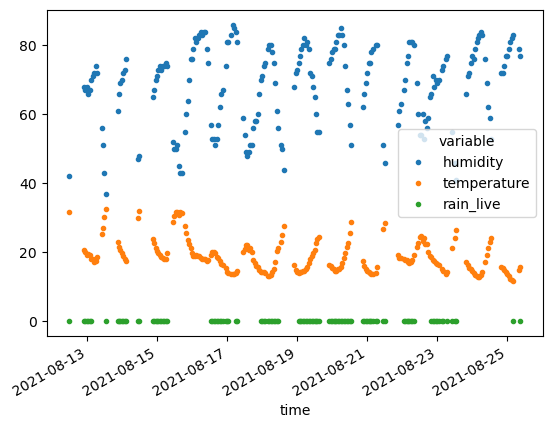

In [7]:
plot_style_kwargs = {"marker": ".", "linestyle": "none"}
ax = module1_ts_df.loc[station_id].plot(**plot_style_kwargs)
module2_ts_df.loc[station_id].plot(ax=ax, **plot_style_kwargs)

We can see that the rain module has a lot of missing values. Therefore, it may make sense to index them differently.

In [8]:
def tstore_num_files(ts_data, partition_cols):
    with tempfile.TemporaryDirectory() as tmp_dir:
        TS(ts_data).to_tstore(tmp_dir, partition_cols)
        return len(glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True))


partition_cols = ["month", "day", "hour"]
print(
    "Number of files for module 1: "
    f"{tstore_num_files(module1_ts_df.loc[station_id], partition_cols)}"
)
print(
    "Number of files for module 2: "
    f"{tstore_num_files(module2_ts_df.loc[station_id], partition_cols)}"
)

Number of files for module 1: 211
Number of files for module 2: 119


In [ ]:
module_2_ts = TS(module2_ts_df.loc[station_id])
with tempfile.TemporaryDirectory() as tmp_dir:
    module_2_ts.to_tstore(tmp_dir, ["month", "day", "hour"])
    # bigtree.print_tree(
    #     bigtree.list_to_tree(
    #         glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True)
    #     )
    # )
    files = glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True)
print(len(files))

In [ ]:
df = (
    ts_df.set_index(["variable", "id", "time"])["value"]
    .unstack(level="variable")
    .loc["70:ee:50:7a:e3:4a"]
)
df

In [ ]:
df[~df["rain_live"].isna()]

In [ ]:
station_obs_count_ser = ts_df.groupby("id")["value"].count()
prop_nan_df = (
    ts_df.set_index(["variable", "id", "time"])["value"]
    .unstack(level="variable")
    .isna()
    .groupby(level="id")
    .sum()
    .apply(lambda x: x / station_obs_count_ser)
)
prop_nan_df

In [ ]:
prop_nan_df["wind_angle"].sort_values()

In [ ]:
station_id, var = ts_df.sample(1).iloc[0].loc[["id", "variable"]]
ts_ser = (
    ts_df.set_index(["id", "variable"])
    .sort_index()
    .loc[(station_id, var)]
    .reset_index(drop=True)
    .set_index("time")
    .rename(columns={"value": var})[var]
)
ts_ser

In [ ]:
ts = TS(pa.Table.from_pandas(ts_ser.to_frame()))
ts

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    ts.to_tstore(tmp_dir, "week")
    bigtree.print_tree(
        bigtree.list_to_tree(
            glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True)
        )
    )

In [ ]:
def generate_ts_array():
    pass

In [ ]:
pa.array([])

In [ ]:
# table = pa.Table.from_pandas(add_partitioning_cols(ts_df))
# partition by date (day) - see https://dataintellect.com/blog/apache-arrow-and-partitioned-datasets/
# table = pa.Table.from_pandas(ts_df.assign(time=ts_df["time"].dt.strftime("%d-%m-%y")))
table = pa.Table.from_pandas(ts_df)
table

In [ ]:
def add_partition_cols(table, partition_cols):
    if isinstance(partition_cols, str):
        partition_cols = [partition_cols]
    for partition_col in partition_cols:
        table = table.append_column(
            partition_col, getattr(pc, partition_col)(table.column("time"))
        )
    return table


add_partition_cols(table, "week")

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    # we assume that our data size scales mainly with space and time rather than other categorical variables
    # we also want to avoid over-partitioning our data (official recommendations are of large row groups: 512MB-1GB https://parquet.apache.org/docs/file-format/configurations/)
    pq.write_to_dataset(
        add_partition_cols(table, "week"), tmp_dir, partition_cols=["variable", "week"]
    )
    bigtree.print_tree(
        bigtree.list_to_tree(
            glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True)
        )
    )
    # print(glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True))

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    # we assume that our data size scales mainly with space and time rather than other categorical variables
    # we also want to avoid over-partitioning our data (official recommendations are of large row groups: 512MB-1GB https://parquet.apache.org/docs/file-format/configurations/)
    pq.write_to_dataset(
        add_partition_cols(table, "week"), tmp_dir, partition_cols=["id", "week"]
    )
    bigtree.print_tree(
        bigtree.list_to_tree(
            glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True)[:50]
        )
    )

In [ ]:
def add_partitioning_cols(df):
    """Add partitioning columns to the dataframe."""
    # TODO: as function of TS_partitioning_string (YYYY/MM/DD) or (YY/DOY/HH)
    # dayofyear, dayofweek, hour,  minute, ...
    df = df.copy()
    df["day"] = df["time"].dt.day.values
    # df["month"] = df["time"].dt.month.values
    # df["year"] = df["time"].dt.year.values
    # partition_on = ["year", "month"]
    return df  # , partition_on

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    # we assume that our data size scales mainly with space and time rather than other categorical variables
    # we also want to avoid over-partitioning our data (official recommendations are of large row groups: 512MB-1GB https://parquet.apache.org/docs/file-format/configurations/)
    pq.write_to_dataset(table, tmp_dir, partition_cols=["id", "time"])
    bigtree.print_tree(
        bigtree.list_to_tree(
            glob.glob(path.join(tmp_dir, "**", "*.parquet"), recursive=True)
        )
    )

In [ ]:
schema = pa.Schema.from_pandas(ts_df)
schema